In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
import igraph as ig

In [3]:
from importlib import resources

In [4]:
import vmlab

reloaded


Data analysis on entire trees don't really lead to great results. The independant branches from F14 tree are thus considered, taking into account this time the light environment of the GUs, and if possible the effect of distance.

# Potential variables for explaining fruit growth : exemple of one branch

### Data

Sunlight fractions : computed from fisheye pictures of the GUs environments on the tree. The mean value on the fruting season is used here (to get only one value for each GU).

In [5]:
with resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_F14.csv') as sunlit_fractions_file_path:
    sunlit_fraction_df = pd.read_csv(
            sunlit_fractions_file_path,
            sep='\\s+')
sunlit_fraction_df

,F14_01,F14_02,F14_03,F14_04,F14_05A,F14_05B,F14_06,F14_08A,F14_08B,F14_08C,...,F14_13B,F14_24A,F14_24B,F14_24E,F14_25D,F14_28A,F14_28B,F14_28C,F14_30B,mean
0,0.136813,0.352094,0.191323,0.272562,0.13125,0.16075,0.256937,0.268073,0.294792,0.293052,...,0.115958,0.032958,0.07225,0.061792,0.04724,0.097198,0.036469,0.070813,0.111479,0.219716


Tree chosen for the whole notebook :

In [6]:
tree_name = 'F14'

In [7]:
id = '24'

branch_path = resources.path('vmlab.data.trees', "".join(("branch_", tree_name,"_", id, ".csv")))
branch = pd.read_csv(branch_path)
graph = vmlab.to_graph(branch)
graph_weighted = vmlab.to_weighted_graph(branch)


In [8]:
branch[branch['growth__nb_leaf']!=0]

,id,parent_id,topology__is_apical,arch_dev__pot_flowering_date,arch_dev__pot_nb_inflo,arch_dev__pot_nb_fruit,growth__nb_leaf,growth__radius_gu,appearance__final_length_gu,light_interception__sunlit_fraction_col,environment_id
7,7,6.0,0.0,NaT,NaN,NaN,6,0.458,5,3,F14_24B
8,8,7.0,1.0,NaT,NaN,NaN,8,0.358,7,3,F14_24B
9,9,3.0,0.0,NaT,NaN,NaN,2,0.249,5,3,F14_24C
13,13,12.0,1.0,NaT,NaN,NaN,5,0.281,5,3,F14_24C
14,14,11.0,0.0,NaT,NaN,NaN,1,0.485,6,3,F14_24C
15,15,14.0,0.0,NaT,NaN,NaN,6,0.371,7,3,F14_24C
16,16,14.0,0.0,NaT,NaN,NaN,5,0.313,7,3,F14_24C
18,18,17.0,0.0,NaT,NaN,NaN,5,0.496,6,3,F14_24C
22,22,21.0,1.0,NaT,NaN,NaN,2,0.399,4,3,F14_24D
23,23,22.0,1.0,NaT,NaN,NaN,7,0.299,7,3,F14_24D


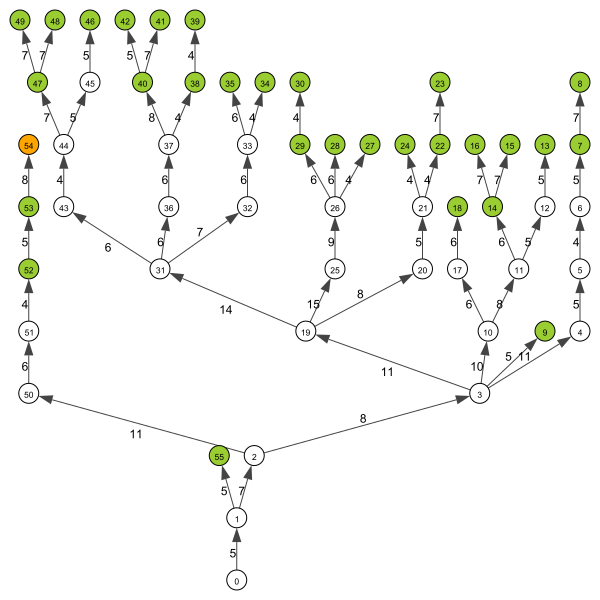

In [251]:
layout = graph_weighted.layout_reingold_tilford()
layout.rotate(-180)
ig.plot(graph_weighted, bbox=(0,0,600,600), 
        layout=layout, 
        vertex_label=graph_weighted.vs.get_attribute_values('id'),
        vertex_label_size = 8.5,
        vertex_color = ['orange' if f>0 else 'yellowgreen' if l>0 else 'white' for f,l in zip(
            graph_weighted.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
            graph_weighted.vs.get_attribute_values('growth__nb_leaf')
        )],
        edge_label = graph_weighted.es['weight'])


Fruits masses for the whole tree :

In [252]:
with resources.path('vmlab.data.fruit_quality', 'fruits_masses.csv') as path:
    fruit_mass = pd.read_csv(path,
                        usecols=[ 'arbre', 'id_UC', 'id_branche', 'id_fruit', 'MS_ini', 'MF_rec'],
                        sep=";"
                        )
fruit_mass = fruit_mass[fruit_mass['arbre']== tree_name ]
fruit_mass.index=fruit_mass['id_branche']

fruit_mass = fruit_mass[fruit_mass.index.notna()]
fruit_mass.drop(labels = [i for i in fruit_mass.index if pd.isna(fruit_mass.loc[i, 'MF_rec'])], axis=0, inplace=True)

fruit_mass = fruit_mass.sort_index()

fruit_mass

,arbre,id_branche,id_fruit,id_UC,MS_ini,MF_rec
id_branche,,,,,,
1.0,F14,1.0,1,2.0,10.193409,203.56
2.0,F14,2.0,2,2.0,16.448879,234.19
3.0,F14,3.0,3,3.0,10.520874,136.01
4.0,F14,4.0,4,2.0,9.685426,110.68
5.0,F14,5.0,5,4.0,10.904737,287.14
6.0,F14,6.0,6,3.0,10.498720,122.94
8.0,F14,8.0,8,5.0,7.588404,379.71
9.0,F14,9.0,9,2.0,8.135078,148.25
10.0,F14,10.0,10,3.0,9.448475,312.15


## Global exploration of the branch

In [11]:
print("Total leaves on the branch :", np.nansum(branch['growth__nb_leaf']))
print("Total fruits on the branch :", np.nansum(branch['arch_dev__pot_nb_fruit']))
print("Number of GUs on the branch: ", graph.ecount())

Total leaves on the branch : 138
Total fruits on the branch : 1.0
Number of GUs on the branch:  55


List of id of growth units bearing fruits on the studied branch :

In [12]:
fruity_GU = np.flatnonzero(branch['arch_dev__pot_nb_fruit'] > 0)
fruity_GU

array([54], dtype=int64)

In [13]:
branch.loc[fruity_GU, 'arch_dev__pot_nb_fruit']

54    1.0
Name: arch_dev__pot_nb_fruit, dtype: float64

In [253]:
adjacency = np.array(graph.get_adjacency())
print("Length of the longest axe :", np.max(csgraph.shortest_path( 
                                    adjacency,
                                    indices=0,
                                    directed=True
                                    ).astype(np.float32)) )

Length of the longest axe : 5.0


## Collecting variables to explain fruit growth

### Fonctions

Topologic distance : the measurement unit is growth units

In [255]:
def get_var_fruit_growth_topo(branch, dmax, year_sunlit_fractions) : 
    '''
    Returns the carbon available for each GU bearing a fruit in the input tree with different ways of computing it in topologic distances.
    
    Parameters
    ----------
    branch : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'tree' input in the vmlab.create_setup function. An 'environment_id' column is also required.

    year_sunlit_fractions : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'sunlit_fraction_df' input in the vmlab.processes.light_interception initialization.

    dmax : :class:`int` object
        Maximum distance for carbon flows.

    Returns
    -------
    available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env : :class:`numpay.array
    '''
    graph = vmlab.to_graph(branch)
    adjacency = np.array(graph.get_adjacency())

    # Initializaton (setting dtypes)
    distance_to_fruit = np.array([], dtype=np.float32)
    is_in_distance_to_fruit = np.array([], dtype=bool)
    is_fruting = branch['arch_dev__pot_nb_fruit'] > 0

    # Collecting GUs at the chosen distance (with or without successors) from each fruit of the tree :
    if np.any(is_fruting) : 
        distance_to_fruit = csgraph.shortest_path( 
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False
                                    ).astype(np.float32)
    
    distance_to_fruit[distance_to_fruit>dmax] = np.Inf
    is_in_distance_to_fruit = np.isfinite(distance_to_fruit).astype(np.float32)

    # Collecting fruity and leafy GUs among the previously selected GUs :
    reachable_leaves = is_in_distance_to_fruit.copy()
    reachable_fruits = is_in_distance_to_fruit.copy()
    lit_frac = is_in_distance_to_fruit.copy()

    for i in range (len(np.flatnonzero(is_fruting))):
        reachable_leaves [i,is_in_distance_to_fruit[i]==1] = branch.loc[is_in_distance_to_fruit[i]==1,'growth__nb_leaf']
        reachable_fruits [i,is_in_distance_to_fruit[i]==1] = branch.loc[is_in_distance_to_fruit[i]==1,'arch_dev__pot_nb_fruit'] # the fruit itself is taken into account
        lit_frac [i,is_in_distance_to_fruit[i]==1] = year_sunlit_fractions.loc[:,branch.loc[is_in_distance_to_fruit[i]==1,'environment_id']] 

    # Taking into account the fact that some leaves share their carbon production between several fruits :

    leaf_fruit_sharing_number = np.nansum(np.transpose( 
    np.multiply(
        np.transpose(is_in_distance_to_fruit),                                     # GU bearing fruits to take into account
        np.array(branch.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']) # number of fruits on these GUs                                                 
        )),
    axis=0)

    leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number 
    leaf_fruit_sharing_fraction[leaf_fruit_sharing_fraction==np.inf] = 0 

    assert leaf_fruit_sharing_fraction.all() <= 1
    assert leaf_fruit_sharing_fraction.all() >= 0

    # Computing variables of interest (np.nansum to avoid NA propagation) :
    sum_reachable_leaves = np.nansum(reachable_leaves, axis=1)[0]

    sum_reachable_leaves_shared = np.nansum(reachable_leaves*leaf_fruit_sharing_fraction, axis=1)[0]
    available_carbon = np.nansum(lit_frac * reachable_leaves * leaf_fruit_sharing_fraction, axis=1)[0]

    available_carbon_raw = sum_reachable_leaves
    available_carbon_shared = sum_reachable_leaves_shared
    available_carbon_shared_lit_env = available_carbon

    return available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env

Geometric distance : the measurement unit is centimeters

In [16]:
def distance_impact_musca (distance, h):
    return 1/((1+distance)**h)

In [256]:
def get_var_fruit_growth_geom(tree: pd.DataFrame, year_sunlit_fractions: pd.DataFrame, h: float, demand: str) : 
    '''
    Returns the carbon available for each GU bearing a fruit in the input tree with different ways of computing it.
    
    Parameters
    ----------
    tree : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'tree' input in the vmlab.create_setup function. A 'environment_id' column is also required.

    year_sunlit_fractions : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'sunlit_fraction_df' input in the vmlab.processes.light_interception initialization.

    h : :class:`float` object
        Friction parameter for mango wood towards carbon flow.

    demand : :class:`str` object
        Type of sink carbon demand in carbon flow computing : 'DM' (dry mass), 'FM' (fresh mass) or '1' (no mass).

    Returns
    -------
    available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env : :class:`numpay.array
    '''

    graph = vmlab.to_weighted_graph(tree)
    adjacency = np.array(graph.get_adjacency(attribute='weight'))

    # Initializaton (setting dtypes)
    distance_to_fruit = np.array([], dtype= float)
    is_fruting = tree['arch_dev__pot_nb_fruit'] > 0

    if np.any(is_fruting) :
        distance_to_fruit = csgraph.shortest_path(
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False,
                                    unweighted = False
                                    ).astype( float)
        
    carbon_flow_raw  = distance_to_fruit.copy()
    carbon_flow_shared  = distance_to_fruit.copy()
    carbon_flow_lit_env  = distance_to_fruit.copy()
    coef_distance = distance_impact_musca(distance_to_fruit, h)

    carbon_sinks = np.copy(coef_distance)
    if demand == 'DM' :
        for j in range (0, len(coef_distance[0])) :
            carbon_sinks[:,j] = coef_distance[:,j] * fruit_mass.loc[np.flatnonzero(is_fruting), 'MS_ini'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
    
    elif demand == 'FM' :
        for j in range (0, len(coef_distance[0])) :
            carbon_sinks[:,j] = coef_distance[:,j] * fruit_mass.loc[np.flatnonzero(is_fruting), 'MF_rec'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']

    else :
        for j in range (0, len(coef_distance[0])) :
            carbon_sinks[:,j] = coef_distance[:,j] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']

    for j in range (0, len(distance_to_fruit)):
        carbon_flow_raw[j] = (coef_distance[j] * tree["growth__nb_leaf"]) #envoi de carbone sans limitation 
        carbon_flow_shared[j] = (carbon_sinks[j] * tree["growth__nb_leaf"]  ) / np.nansum(carbon_sinks, axis=0) # envoi d'autant de carbone que disponible dans les feuilles
        carbon_flow_lit_env[j] = (carbon_sinks[j] * tree["growth__nb_leaf"] * year_sunlit_fractions[tree["environment_id"]].to_numpy()[0] ) / np.nansum(carbon_sinks, axis=0) # envoi d'autant de carbone que disponible dans les feuilles selon la capacité de photosynthèse

    available_carbon_raw = np.round(np.nansum(carbon_flow_raw, axis=1), decimals=2)
    available_carbon_shared = np.round(np.nansum(carbon_flow_shared, axis=1), decimals=2)
    available_carbon_shared_lit_env = np.round(np.nansum(carbon_flow_lit_env, axis=1), decimals=2)

    return available_carbon_raw, available_carbon_shared, available_carbon_shared_lit_env

# Results

In [18]:
example = pd.DataFrame(get_var_fruit_growth_topo(branch, 2, sunlit_fraction_df), columns=[id], index=["LF leaves", "LF sharing", "LF light env"])
example

C:\Users\bolot\AppData\Local\Temp\ipykernel_13716\2760210918.py:42: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number


,24
LF leaves,21.000000
LF sharing,21.000000
LF light env,0.692125


In [19]:
h=0.4

In [20]:
coef = np.round(distance_impact_musca(csgraph.shortest_path(np.array(graph_weighted.get_adjacency(attribute='weight')),
                                                indices = np.flatnonzero(branch['arch_dev__pot_nb_fruit'] > 0),
                                                directed= False,
                                                unweighted = False).astype(np.float32), 
                                                h=h), decimals=2)
coef

array([[0.21, 0.22, 0.24, 0.22, 0.2 , 0.2 , 0.19, 0.18, 0.18, 0.21, 0.2 ,
        0.19, 0.19, 0.18, 0.19, 0.18, 0.18, 0.2 , 0.19, 0.2 , 0.19, 0.19,
        0.18, 0.18, 0.18, 0.18, 0.18, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18,
        0.17, 0.17, 0.17, 0.18, 0.17, 0.17, 0.17, 0.17, 0.16, 0.16, 0.18,
        0.18, 0.17, 0.17, 0.17, 0.16, 0.16, 0.28, 0.31, 0.35, 0.42, 1.  ,
        0.21]], dtype=float32)

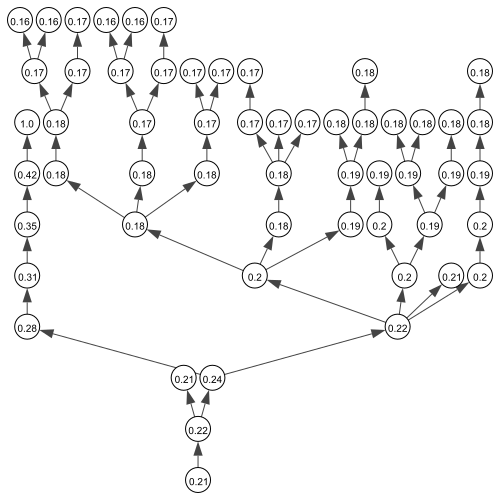

In [37]:
layout = graph_weighted.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph_weighted, 
    bbox=(0,0,500,500), 
    layout=layout,
    vertex_label = coef[0],
    vertex_size = 25,
    vertex_label_size = 10,
    vertex_color="white")

In [22]:
example2 = pd.DataFrame(get_var_fruit_growth_geom(branch, sunlit_fraction_df, h=h, demand='1'), columns=[id], index=["LF leaves", "LF sharing", "LF light env"])
example2

,24
LF leaves,35.95
LF sharing,138.00
LF light env,23.70


## Collecting data on all branches of F14 for topologic distances

In [23]:
# collecting variables at the distance dmax :
branch_names = ['01','02','03','04','05','06','08','09','10','11','12','13','14','15','16','17','19','20','21','23','24','25','26','27','28','29','30']
distances = np.linspace(0,22,23)
branches = ["".join(("branch_F14_",id,".csv")) for id in branch_names]
results = [[get_var_fruit_growth_topo(pd.read_csv(resources.path('vmlab.data.trees', name)), d, sunlit_fraction_df) for name in branches] for d in distances ]

C:\Users\bolot\AppData\Local\Temp\ipykernel_13716\2760210918.py:42: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_13716\2760210918.py:42: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_13716\2760210918.py:42: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_13716\2760210918.py:42: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_13716\2760210918.py:42: RuntimeWarning: divide by zero encountered in true_divide
  leaf_fruit_sharing_fraction = 1/ leaf_fruit_sharing_number
C:\Users\bolot\AppData\Local\Temp\ipykernel_13716\2760210918.py:4

In [24]:
col_names = pd.MultiIndex.from_product(([i for i in distances],["raw carbon", "shared carbon","shared light carbon"],), names=['distance',"variable"])
final_table =pd.DataFrame(np.hstack(results), columns=col_names, index=fruit_mass.index)
final_table = final_table.swaplevel("distance","variable",1).sort_index(axis=1,level="variable")
final_table['fresh_mass']=fruit_mass['MF_rec']
final_table['dry_mass']=fruit_mass['MS_ini']
final_table = np.transpose(final_table)
final_table

id_branche                          1.0         2.0         3.0         4.0   \
variable            distance                                                   
raw carbon          0.0         7.000000    6.000000    5.000000   10.000000   
                    1.0        20.000000   22.000000    9.000000   16.000000   
                    2.0        40.000000   22.000000   15.000000   16.000000   
                    3.0        40.000000   22.000000   21.000000   16.000000   
                    4.0        40.000000   22.000000   26.000000   16.000000   
...                                  ...         ...         ...         ...   
shared light carbon 20.0        6.550243    7.746063    4.974396    5.633500   
                    21.0        6.550243    7.746063    4.974396    5.633500   
                    22.0        6.550243    7.746063    4.974396    5.633500   
fresh_mass                    203.560000  234.190000  136.010000  110.680000   
dry_mass                       10.193409   16.448879   10.520874    9.685426   

id_branche                          5.0         6.0         8.0         9.0   \
variable            distance                                                   
raw carbon          0.0         7.000000    1.000000    9.000000   10.000000   
                    1.0        19.000000    5.000000   13.000000   24.000000   
                    2.0        21.000000    6.000000   15.000000   24.000000   
                    3.0        21.000000    9.000000   15.000000   24.000000   
                    4.0        25.000000   14.000000   15.000000   24.000000   
...                                  ...         ...         ...         ...   
shared light carbon 20.0        8.022416    3.597125   18.982406    5.325500   
                    21.0        8.022416    3.597125   18.982406    5.325500   
                    22.0        8.022416    3.597125   18.982406    5.325500   
fresh_mass                    287.140000  122.940000  379.710000  148.250000   
dry_mass                       10.904737   10.498720    7.588404    8.135078   

id_branche                          10.0        11.0  ...        20.0  \
variable            distance                          ...               
raw carbon          0.0        17.000000   16.000000  ...   12.000000   
                    1.0        31.000000   21.000000  ...   21.000000   
                    2.0        56.000000   26.000000  ...   68.000000   
                    3.0        56.000000   34.000000  ...   68.000000   
                    4.0        56.000000   34.000000  ...   68.000000   
...                                  ...         ...  ...         ...   
shared light carbon 20.0       10.782041    9.905334  ...   27.056917   
                    21.0       10.782041    9.905334  ...   27.056917   
                    22.0       10.782041    9.905334  ...   27.056917   
fresh_mass                    312.150000  193.860000  ...  353.210000   
dry_mass                        9.448475    9.300269  ...   10.198782   

id_branche                          21.0        23.0        24.0        25.0  \
variable            distance                                                   
raw carbon          0.0        10.000000   18.000000   12.000000    7.000000   
                    1.0        14.000000   25.000000   18.000000   14.000000   
                    2.0        41.000000   42.000000   21.000000   15.000000   
                    3.0        41.000000   42.000000   21.000000   20.000000   
                    4.0        42.000000   42.000000   21.000000   20.000000   
...                                  ...         ...         ...         ...   
shared light carbon 20.0       22.576905   17.697114   23.704542   24.651070   
                    21.0       22.576905   17.697114   23.704542   24.651070   
                    22.0       22.576905   17.697114   23.704542   24.651070   
fresh_mass                    495.460000  305.310000  469.460000  400.430000   
dry_mass

In [25]:
longest_axe =[]
for i in branches :
    branch = pd.read_csv(resources.path('vmlab.data.trees', i))
    graph = vmlab.to_graph(branch)
    longest_axe.append(np.max(csgraph.shortest_path( 
        np.array(graph.get_adjacency()),
        indices=np.flatnonzero(branch['arch_dev__pot_nb_fruit']>0),
        directed=False
        ).astype(np.float32)) )
print("Axe le plus long des branches :", np.max(longest_axe))

Axe le plus long des branches : 21.0


In [26]:
from math import ceil

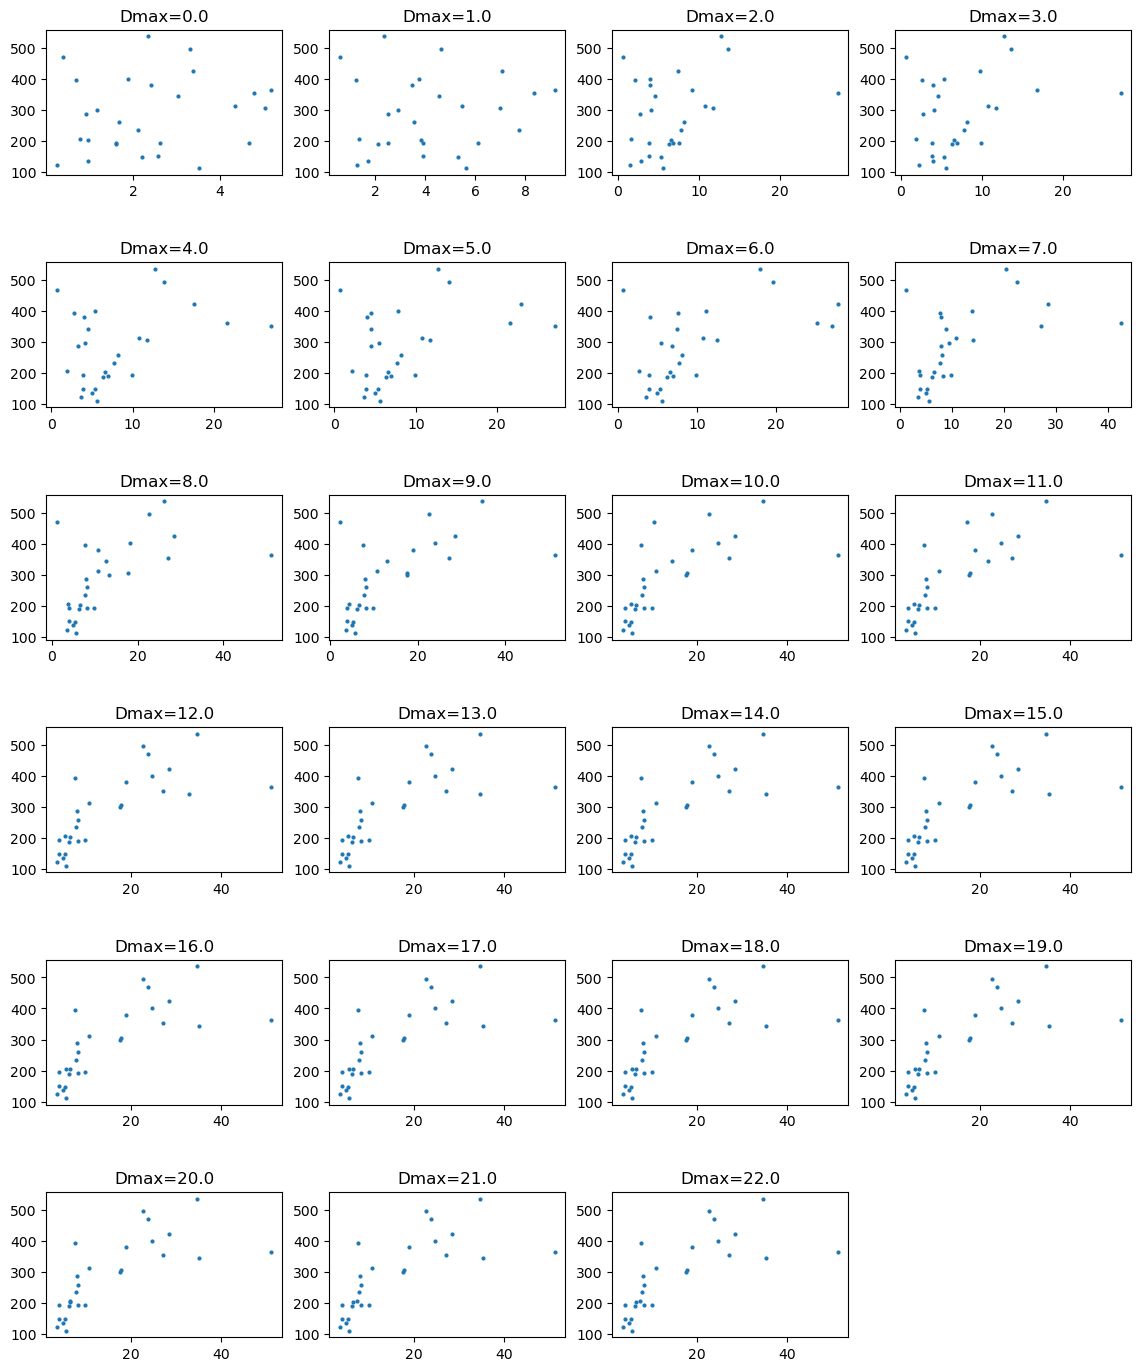

In [249]:
plt.figure(figsize=(14,20))
for i in distances :
    plt.subplot(ceil(len(distances)/4+1), 4, int(i+1))
    plt.scatter(final_table.loc['shared light carbon'].loc[i], final_table.loc['fresh_mass',""], s=4)
    plt.title("".join(("Dmax=", str(i))))
plt.subplots_adjust(hspace=0.6)
plt.show()

Visually, we can see a relation appearing from a distance of 2 or 3 GUs. This has to be confirmed with the fit used on previous analyses ont hese branches (Weibull model).

In [28]:
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf

In [259]:
def model_weibull1(x, asym, k, pwr):
    '''
    Returns the values of the Weibull model not including dry mass.
    
    Parameters
    ----------
    x : :class:`numpy.array` object
        Available carbon.

    asym : :class:`float` object
        Freshfruit mass asymptot in the model.

    k : :class:`float` object
        Parameter of the model.

    pwr : :class:`float` object
        Parameter of the model.

    Returns
    -------
    Values calculated : :class:`numpay.array
    '''
    return asym - asym*np.exp(-k*(x**pwr))

In [263]:
def model_weibull2(x1x2, a, b, k, pwr):
    '''
    Returns the values of the Weibull model including dry mass.
    
    Parameters
    ----------
    x1x2 : :class:`numpy.array` object
        Dry mass at index 0.
        Available carbon at index 1.

    a : :class:`float` object
        Multiplication coefficient for dry mass factor of the model.

    b : :class:`float` object
        Power coefficient for dry mass factor of the model.

    k : :class:`float` object
        Multiplication coefficient for carbon factor of the model.

    pwr : :class:`float` object
        Power coefficient for carbon factor of the model.

    Returns
    -------
    Values calculated : :class:`numpay.array
    '''
    return (a*(x1x2[0]**b)) * (1 - np.exp(-k*(x1x2[1]**pwr)))

In [30]:
def RRMSE (observed, predicted):
    SCE = np.sum((predicted-observed)**2)
    RMSE = np.sqrt(SCE/len(observed))
    RRMSE = 100 * RMSE /np.mean(observed)
    return RRMSE

### Without including initial dry mass :

Dmax choisie : 0
Dmax choisie : 1
Dmax choisie : 2
Dmax choisie : 3
Dmax choisie : 4
Dmax choisie : 5
Dmax choisie : 6
Dmax choisie : 7
Dmax choisie : 8
Dmax choisie : 9
[7.03159829e+02 1.66459540e-01 4.82311755e-01]


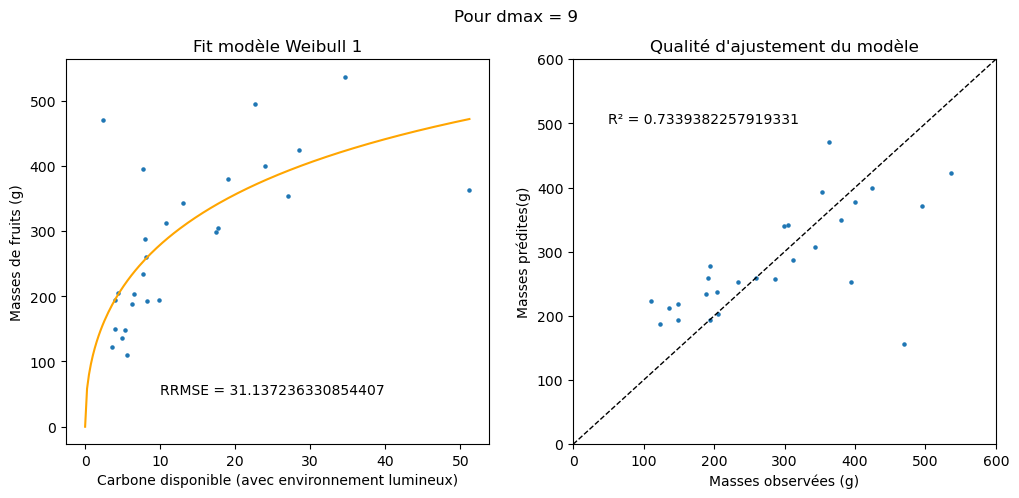

Dmax choisie : 10
[4.25944869e+02 8.68605506e-02 1.12232820e+00]


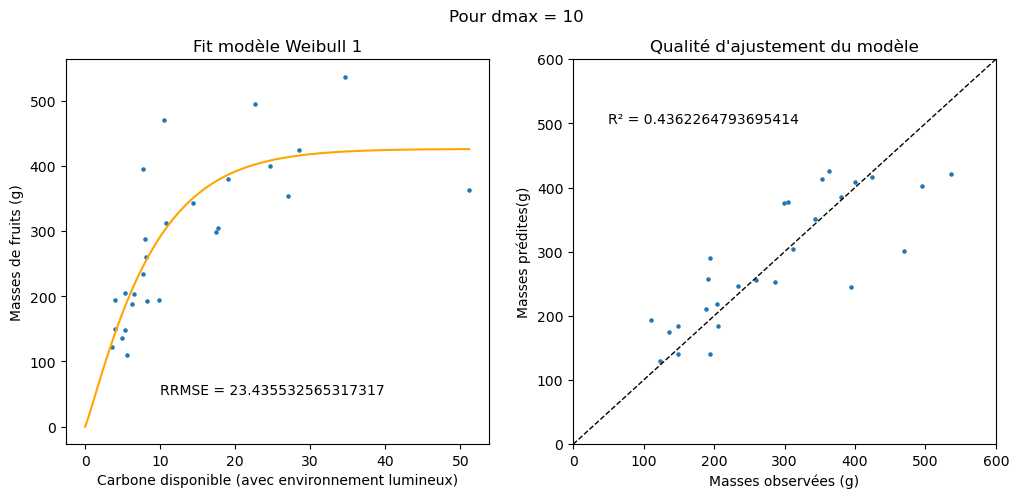

Dmax choisie : 11
[4.33254370e+02 8.99541220e-02 1.06735914e+00]


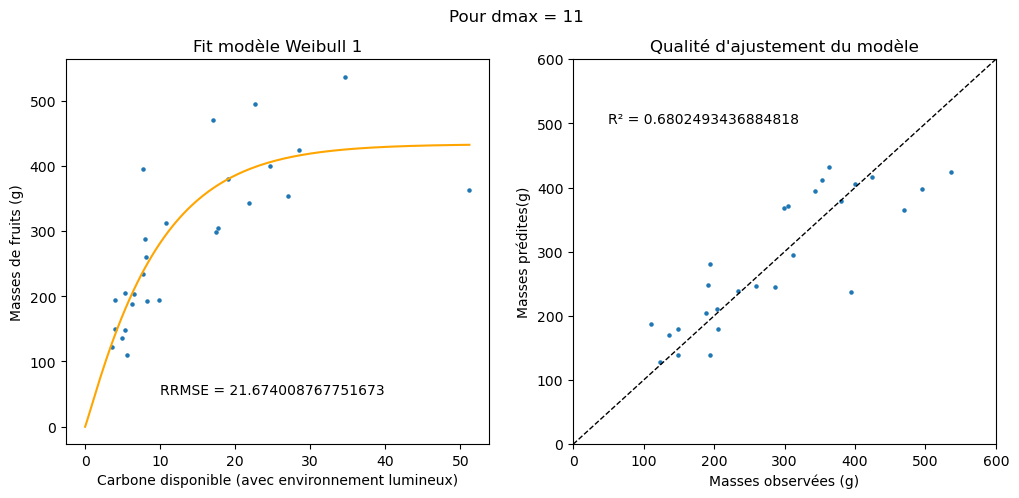

Dmax choisie : 12
[4.27543790e+02 9.14496900e-02 1.06520054e+00]


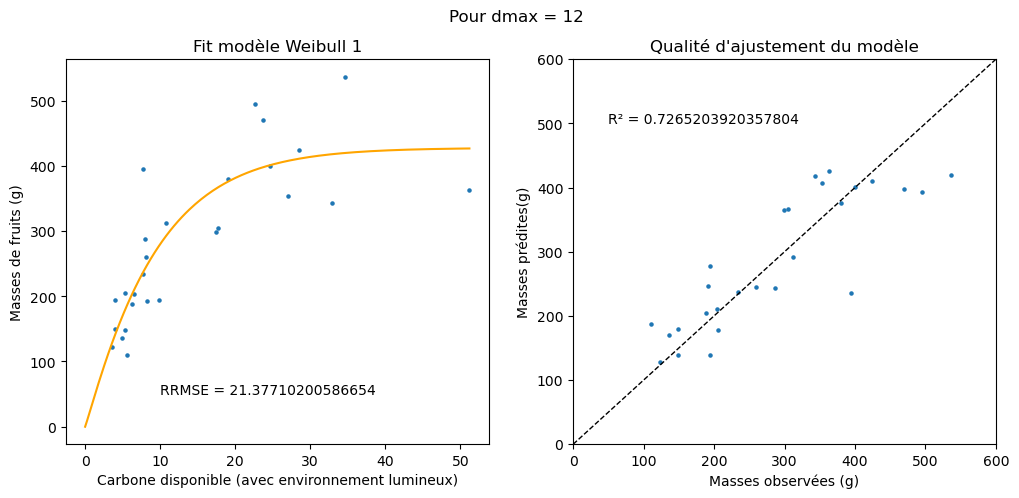

Dmax choisie : 13
[4.25937129e+02 9.02618725e-02 1.07524727e+00]


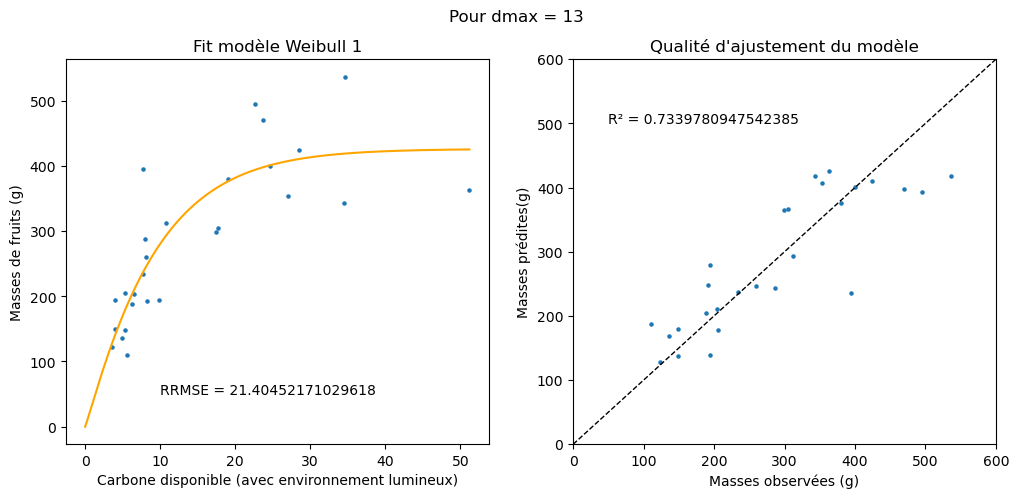

Dmax choisie : 14
[4.25375573e+02 8.98128172e-02 1.07897802e+00]


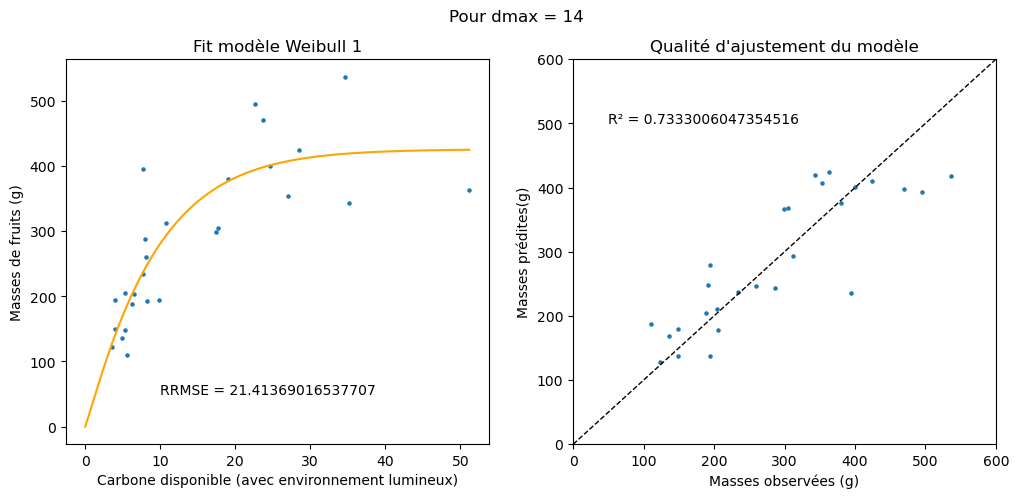

Dmax choisie : 15
[4.25380719e+02 8.98184613e-02 1.07893512e+00]


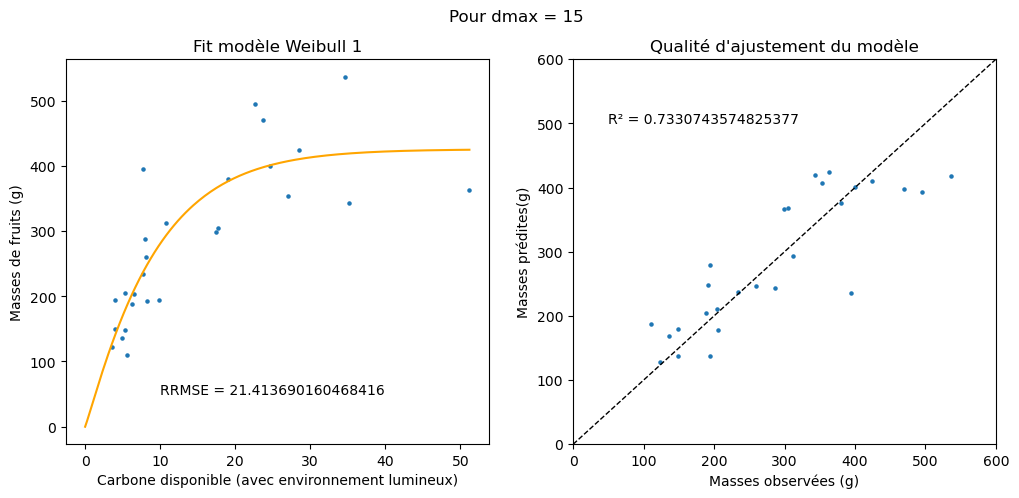

Dmax choisie : 16
[4.25032652e+02 8.81252674e-02 1.08721307e+00]


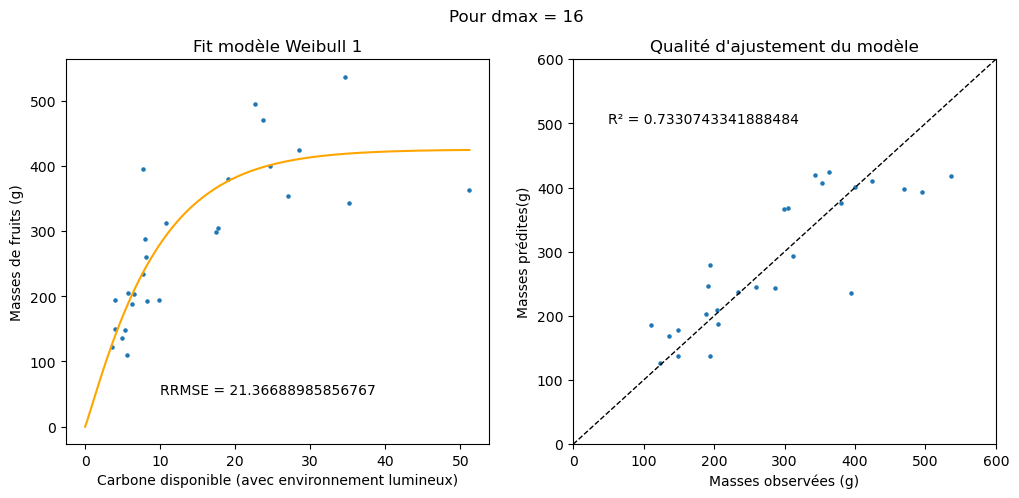

Dmax choisie : 17
[4.25038169e+02 8.81314199e-02 1.08716590e+00]


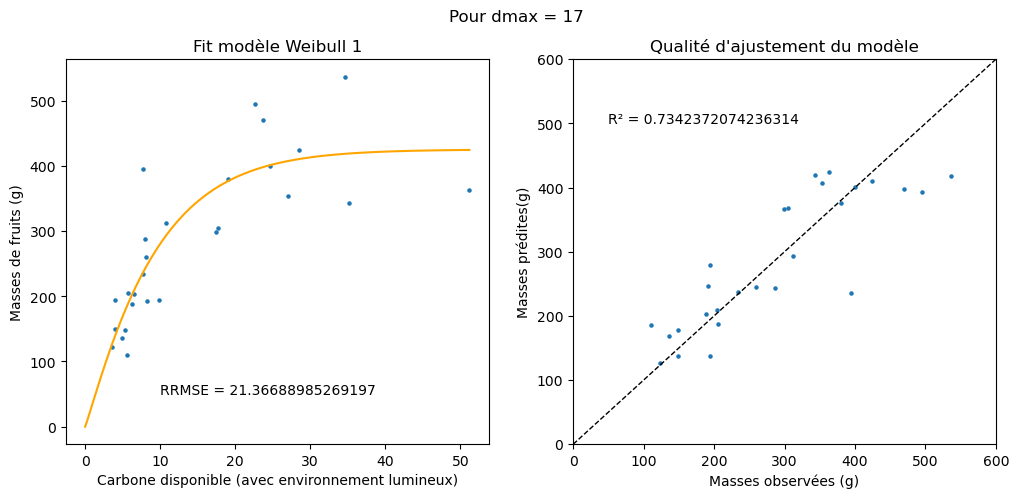

Dmax choisie : 18
[4.25035463e+02 8.81284002e-02 1.08718905e+00]


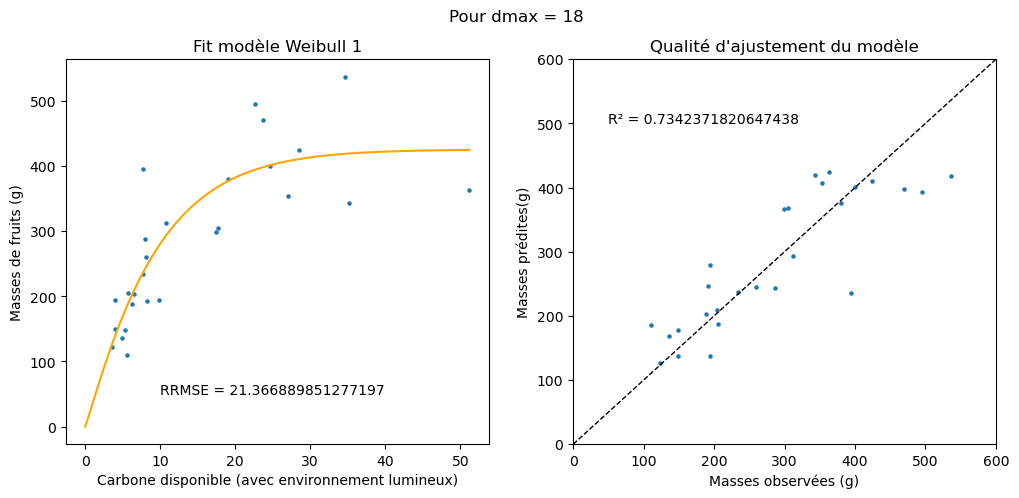

Dmax choisie : 19
[4.25036792e+02 8.81298846e-02 1.08717768e+00]


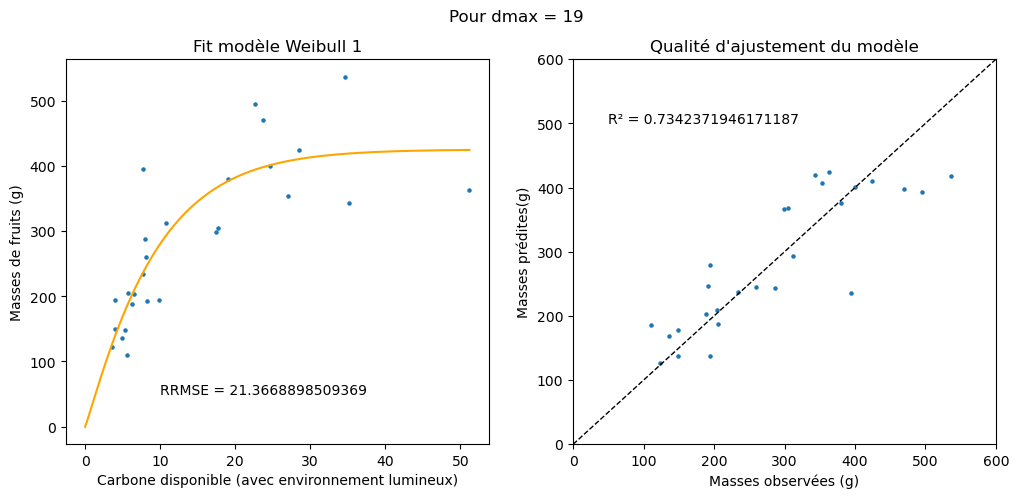

Dmax choisie : 20
[4.24838139e+02 8.51858207e-02 1.09962658e+00]


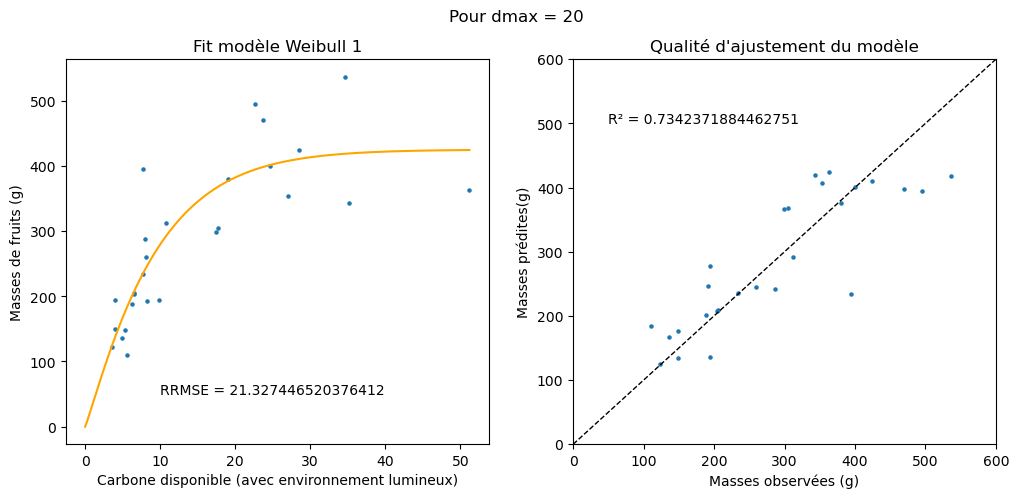

Dmax choisie : 21
[4.25341262e+02 8.41224439e-02 1.10073623e+00]


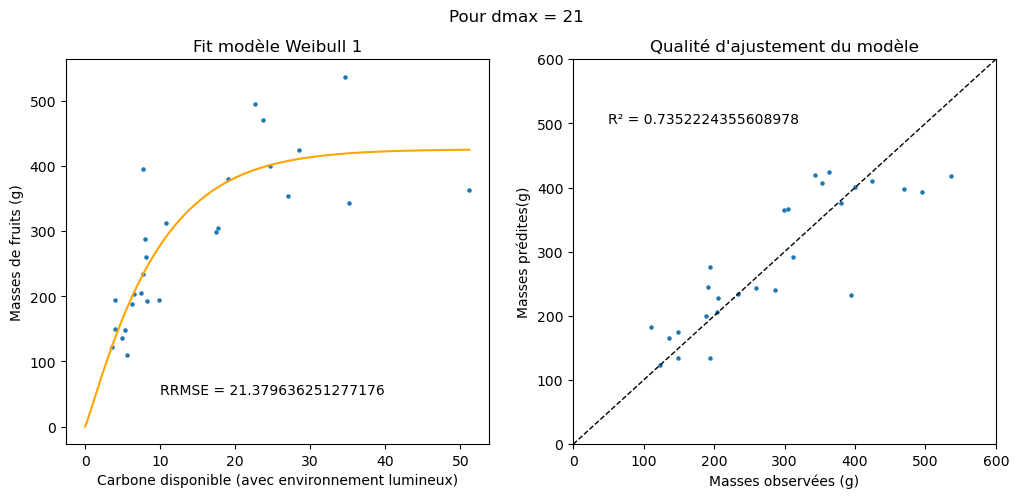

Dmax choisie : 22
[4.25335305e+02 8.41159682e-02 1.10078751e+00]


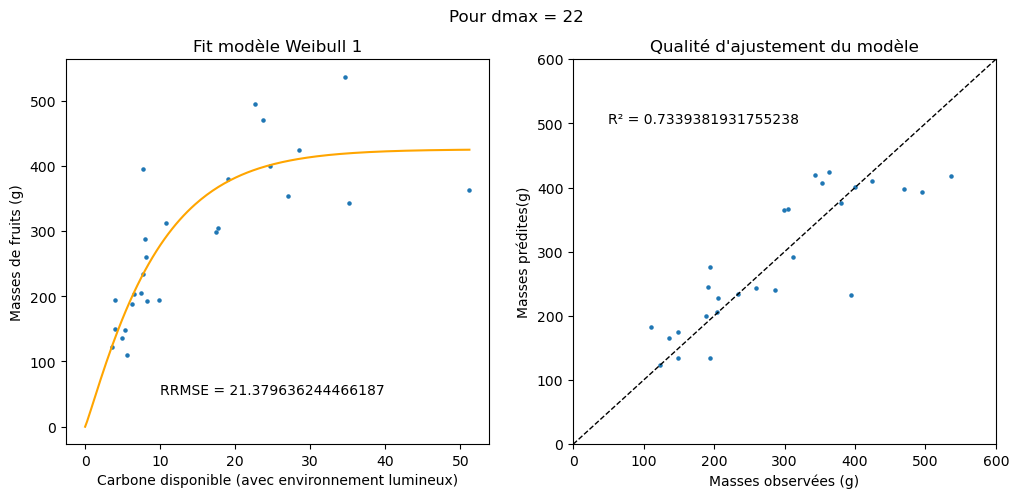

In [257]:
axe=[]
rrmse=[]
rsquared=[]
p0=(425,0.08,1.1) #values of optimization for entire branches
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22] :
    print('Dmax choisie :', i)
    x = final_table.loc['shared light carbon'].loc[i]
    y1 = final_table.loc['fresh_mass',""]
    
    if RRMSE(predicted = model_weibull1(x, p0[0], p0[1], p0[2]), observed = y1) < 36 :
      popt, pcov = curve_fit(f=model_weibull1,
            xdata=x,
            ydata=y1,
            p0=p0)
      print(popt)      
      asym_opt, k_opt, pwr_opt = popt
      p0=(asym_opt,k_opt, pwr_opt)
      y2= model_weibull1(x, asym_opt, k_opt, pwr_opt)
      
      fig=plt.figure(figsize=(12,5))
      fig.suptitle("Pour dmax = "+str(i))

      plt.subplot(121)
      plt.scatter(x, y1, s=5)
      plt.plot(np.linspace(0, np.max(x),200), model_weibull1(np.linspace(0, np.max(x),200),asym_opt, k_opt, pwr_opt), color='orange')
      plt.title(label ="Fit modèle Weibull 1" )
      plt.xlabel('Carbone disponible (avec environnement lumineux)')
      plt.ylabel('Masses de fruits (g)')
      plt.text(x=10, y=50, s= "RRMSE = "+ str(RRMSE(predicted = y2, observed = y1)))

      plt.subplot(122)
      plt.scatter(y1, y2, s=5)
      plt.xlim(0,600)
      plt.ylim(0,600)
      plt.plot([0,600],[0,600], color='black',linewidth=1, linestyle="--")
      plt.title(label ="Qualité d'ajustement du modèle")
      plt.xlabel('Masses observées (g)')
      plt.ylabel('Masses prédites(g)')
      plt.text(x=50, y=500, s= "R² = "+ str(smf.ols('y2 ~ y1', data=sample).fit().rsquared))
      
      plt.subplots_adjust(wspace=0.2)
      plt.show()

      sample=pd.DataFrame({'x':x, 'y1':y1, 'y2':y2})
      axe.append(i)
      rrmse.append(RRMSE(predicted = y2, observed = y1))
      rsquared.append(smf.ols('y2 ~ y1', data=sample).fit().rsquared)

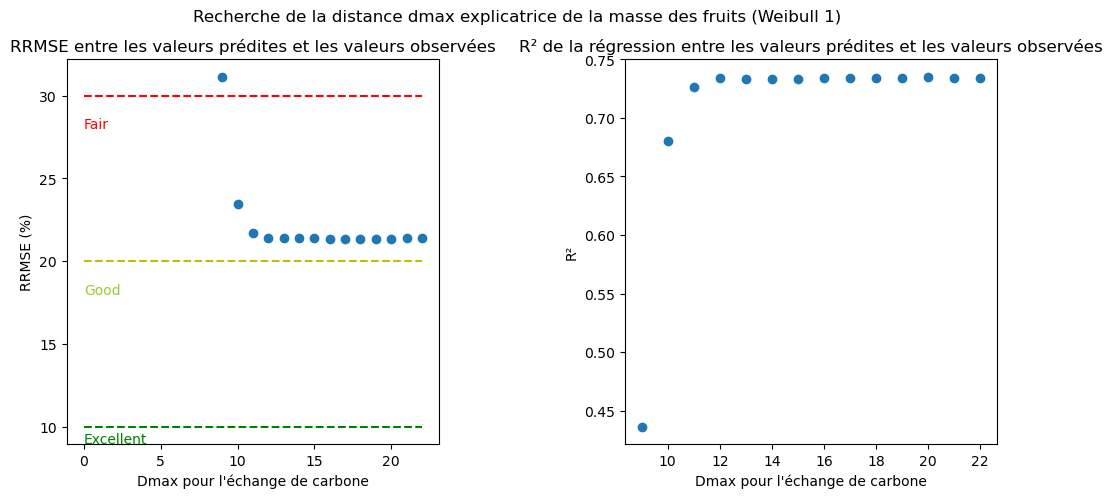

In [258]:
fig=plt.figure(figsize=(12,5))
fig.suptitle("Recherche de la distance dmax explicatrice de la masse des fruits (Weibull 1)")

plt.subplot(121)
plt.scatter(axe, rrmse)
plt.plot([0,22], [10,10], 'g--')
plt.plot([0,22], [20,20], 'y--')
plt.plot([0,22], [30,30], 'r--')
plt.text(x=0, y=9, s="Excellent", c='green')
plt.text(x=0, y=18, s="Good", c='yellowgreen')
plt.text(x=0, y=28, s="Fair", c='red')
plt.title("RRMSE entre les valeurs prédites et les valeurs observées")
plt.xlabel("Dmax pour l'échange de carbone")
plt.ylabel("RRMSE (%)")

plt.subplot(122)
plt.title("R² de la régression entre les valeurs prédites et les valeurs observées")
plt.xlabel("Dmax pour l'échange de carbone")
plt.ylabel("R²")
plt.scatter(axe, rsquared)

plt.subplots_adjust(wspace=0.5)
plt.show()

In [34]:
with resources.path('vmlab.data.results', 'Exploration_F14_fruting_season_topo.csv') as path:
    final_table.to_csv(path_or_buf= path)

### With including initial dry mass :

Dmax choisie : 0
Dmax choisie : 1
Dmax choisie : 2
Dmax choisie : 3
Dmax choisie : 4
Dmax choisie : 5
Dmax choisie : 6
Dmax choisie : 7
Dmax choisie : 8
Dmax choisie : 9
[3.54303553e+02 1.69898940e-01 2.23100575e-01 5.32605347e-01]


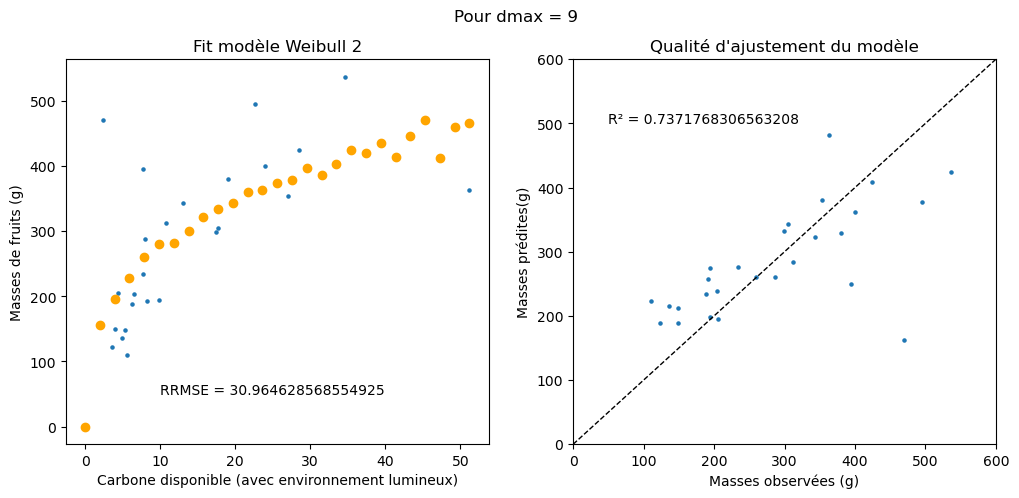

Dmax choisie : 10
[2.50186400e+02 2.05401879e-01 8.18319236e-02 1.20053824e+00]


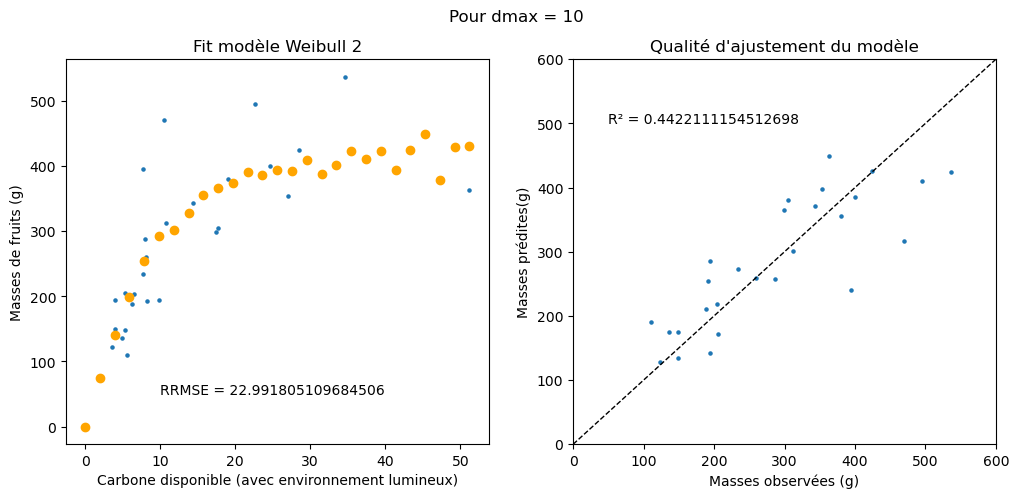

Dmax choisie : 11
[3.22774516e+02 1.10790790e-01 8.84078394e-02 1.10830771e+00]


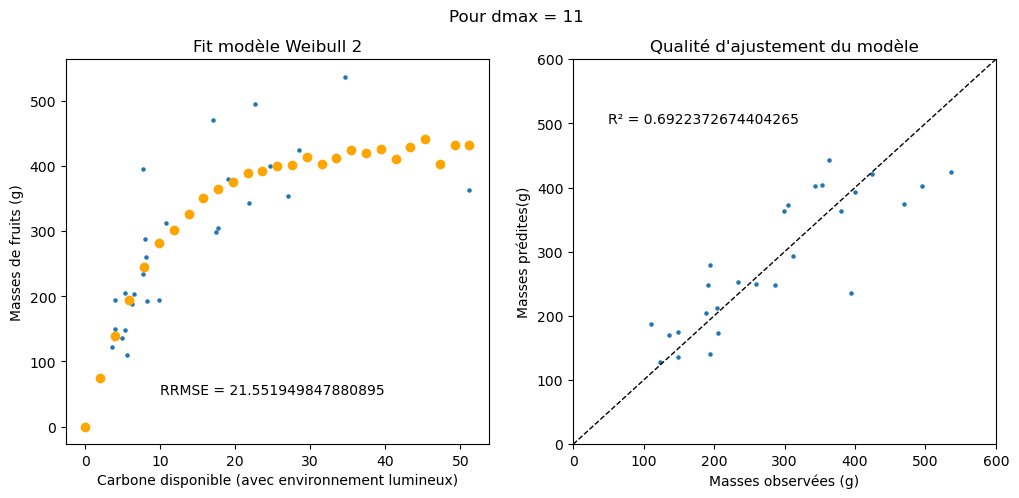

Dmax choisie : 12
[3.43373285e+02 8.25297692e-02 8.96192327e-02 1.10013764e+00]


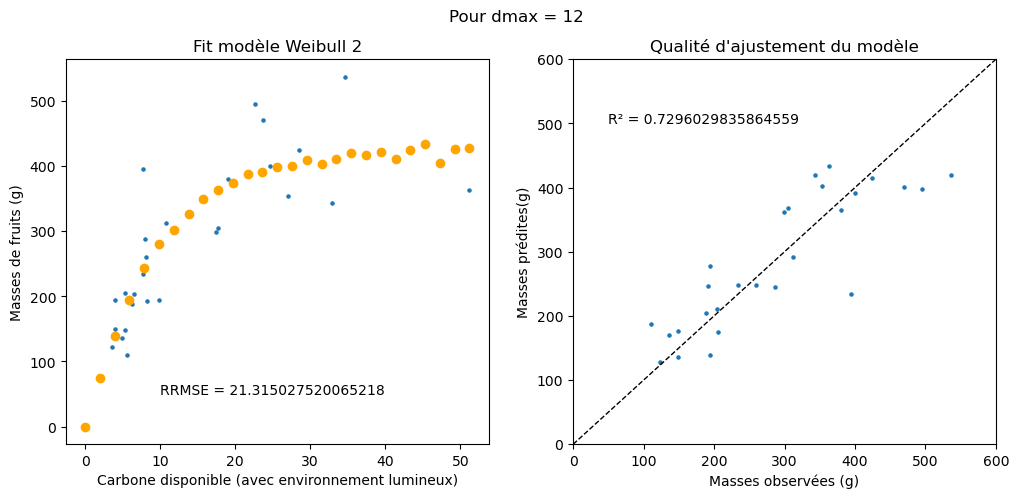

Dmax choisie : 13
[3.39138315e+02 8.62088036e-02 8.84019609e-02 1.11073129e+00]


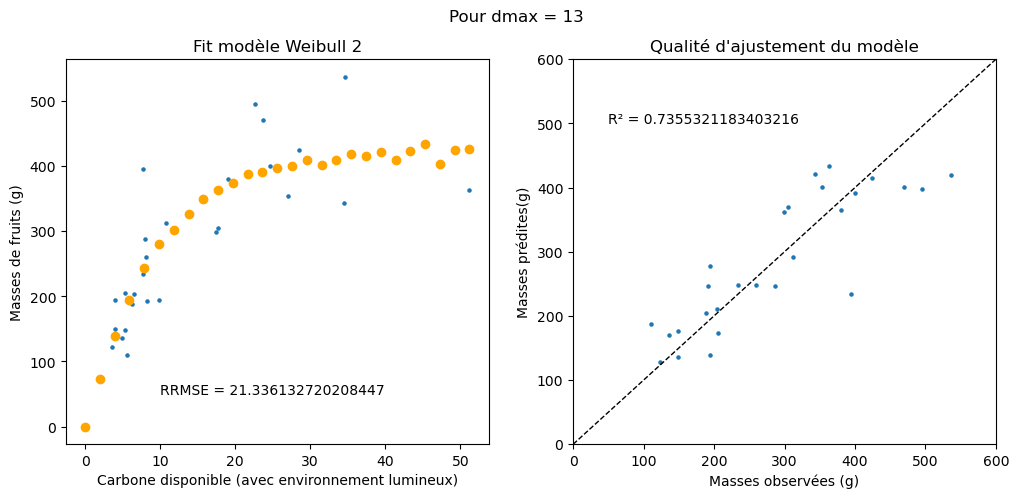

Dmax choisie : 14
[3.37697374e+02 8.74845111e-02 8.79696305e-02 1.11444867e+00]


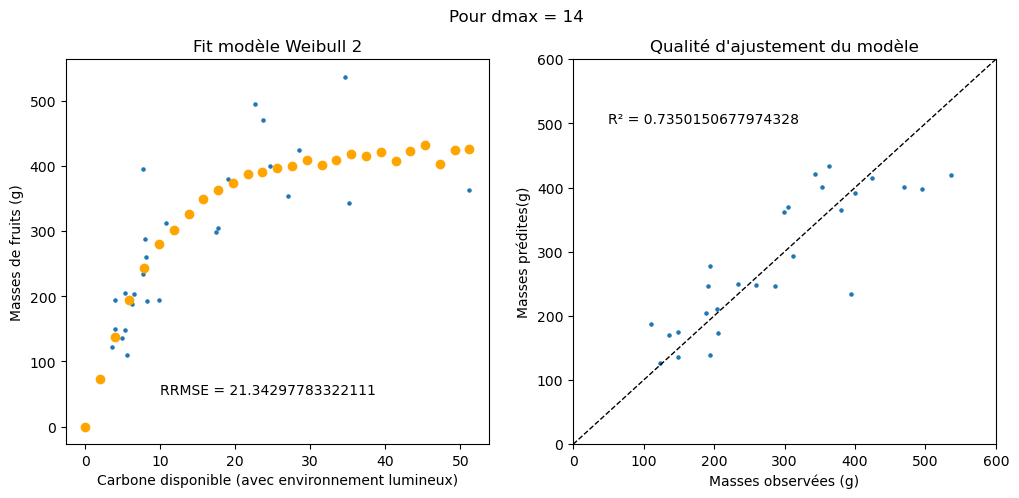

Dmax choisie : 15
[3.37743375e+02 8.74419357e-02 8.79850347e-02 1.11432410e+00]


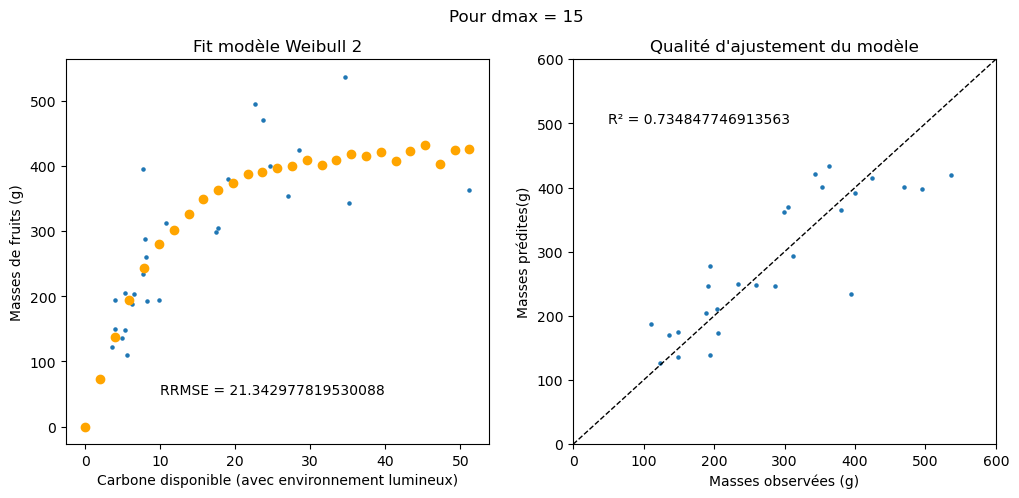

Dmax choisie : 16
[3.32898169e+02 9.26906140e-02 8.60898524e-02 1.12537841e+00]


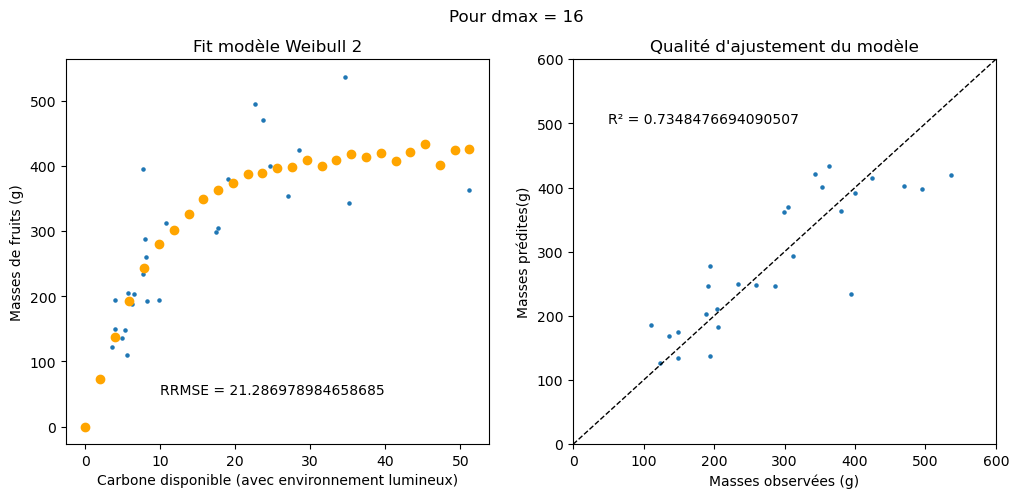

Dmax choisie : 17
[3.32937317e+02 9.26536558e-02 8.61033077e-02 1.12526874e+00]


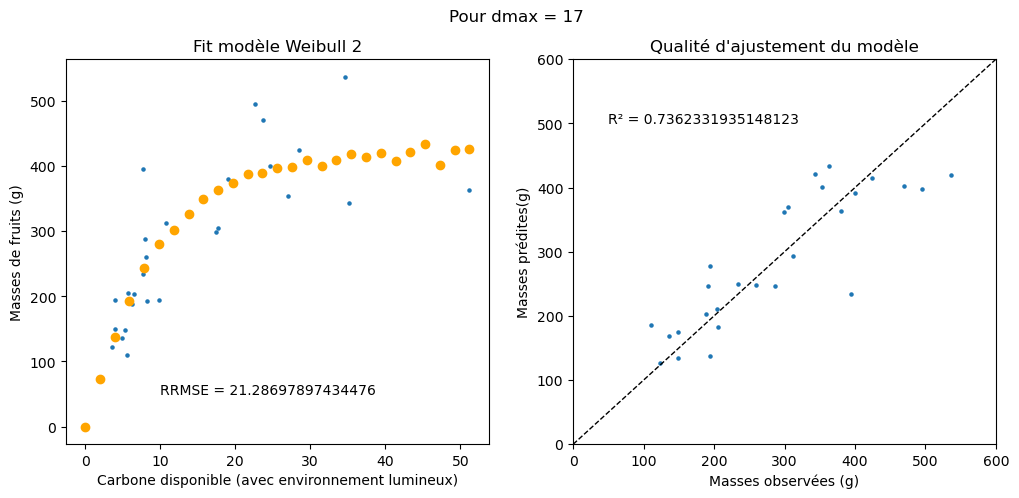

Dmax choisie : 18
[3.32906984e+02 9.26823671e-02 8.60929931e-02 1.12535289e+00]


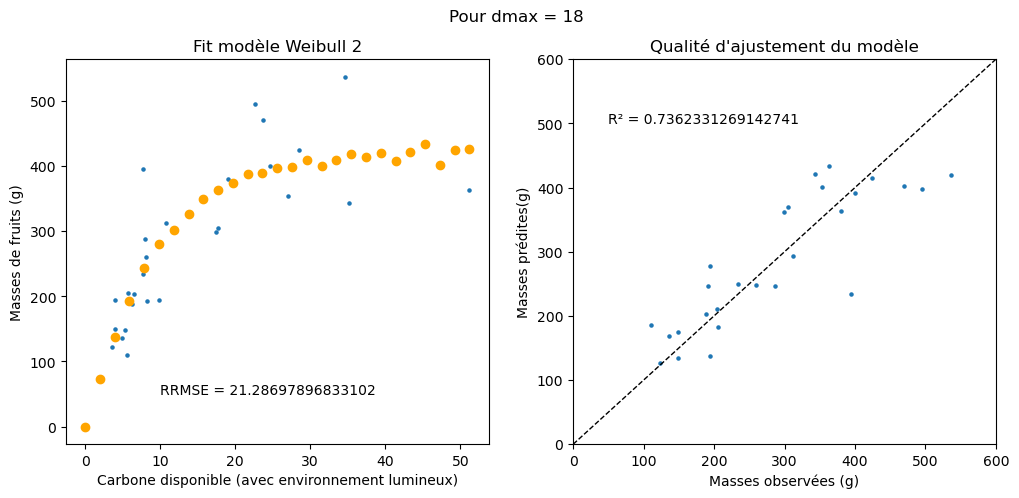

Dmax choisie : 19
[3.32930492e+02 9.26600781e-02 8.61009227e-02 1.12528814e+00]


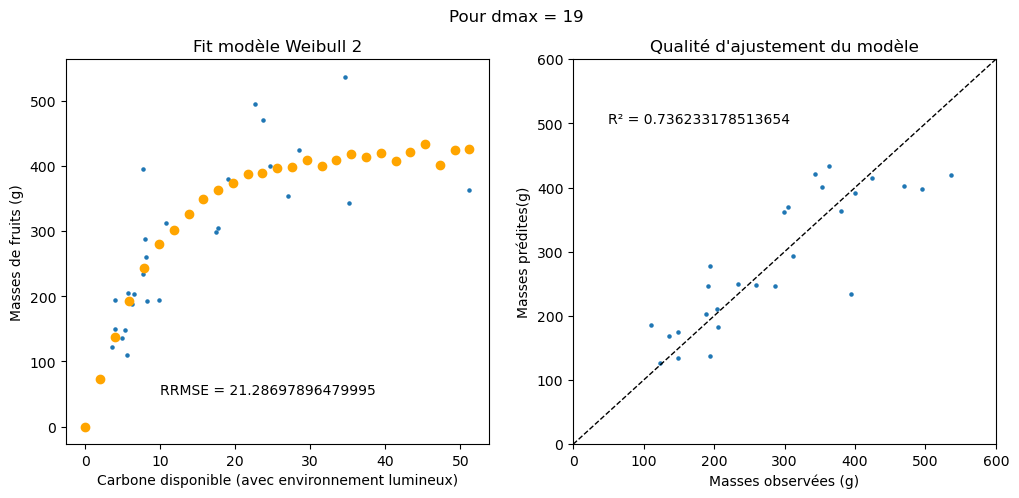

Dmax choisie : 20
[3.21536432e+02 1.05792497e-01 8.27089176e-02 1.14447612e+00]


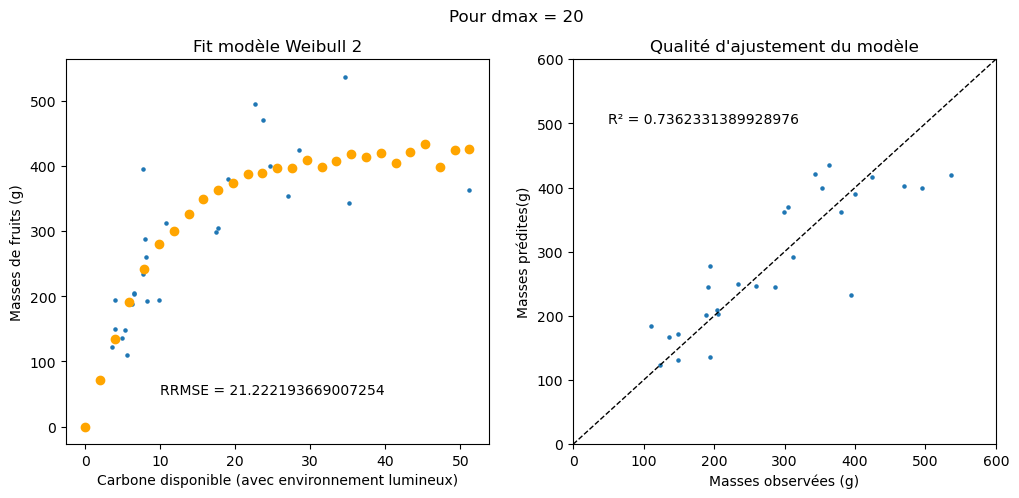

Dmax choisie : 21
[3.12048518e+02 1.17548587e-01 8.13302232e-02 1.15116266e+00]


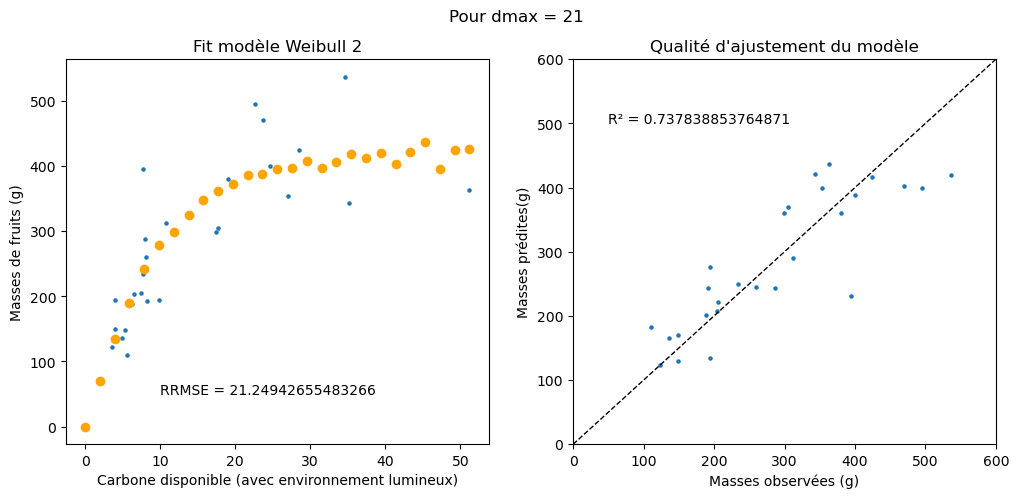

Dmax choisie : 22
[3.12015423e+02 1.17580418e-01 8.13150846e-02 1.15128789e+00]


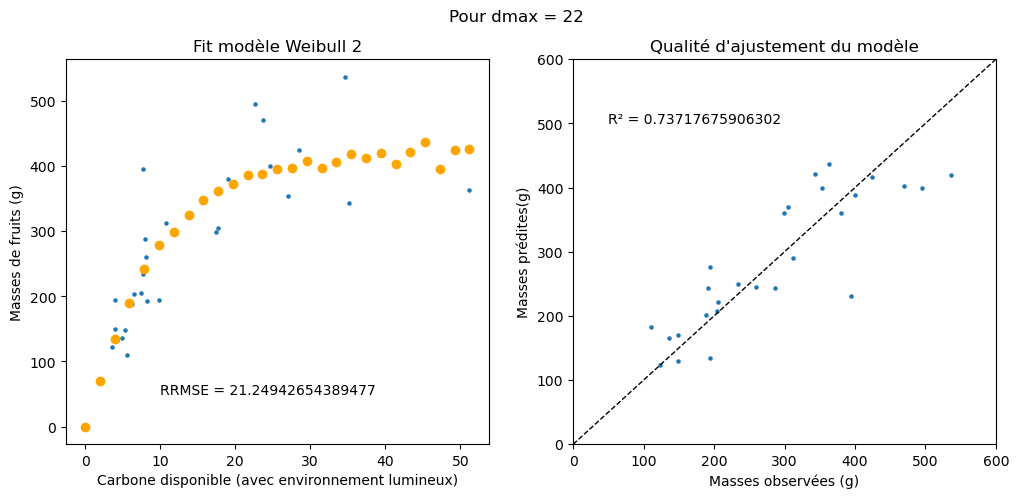

In [270]:
axe=[]
rrmse=[]
rsquared=[]
p0=(312, 0.12, 0.08, 1.15) #values of optimization for entire branches
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22] :
    print('Dmax choisie :', i)
    x1 = final_table.loc['dry_mass',""]
    x2 = final_table.loc['shared light carbon'].loc[i]
    y1 = final_table.loc['fresh_mass',""]
    
    if RRMSE(predicted = model_weibull2([x1,x2], p0[0], p0[1], p0[2], p0[3]), observed = y1) < 36 :
      popt, pcov = curve_fit(f=model_weibull2,
            xdata=[x1,x2],
            ydata=y1,
            p0=p0)
      print(popt)      
      a_opt, b_opt, k_opt, pwr_opt = popt
      p0=(a_opt, b_opt, k_opt, pwr_opt)
      y2= model_weibull2([x1,x2], a_opt, b_opt, k_opt, pwr_opt)
      
      fig=plt.figure(figsize=(12,5))
      fig.suptitle("Pour dmax = "+str(i))

      plt.subplot(121)
      plt.scatter(x2, y1, s=5)
      plt.scatter(np.linspace(0, np.max(x2), len(x1)), model_weibull2([x1,np.linspace(0, np.max(x2), len(x1))],a_opt, b_opt, k_opt, pwr_opt), color='orange')
      plt.title(label ="Fit modèle Weibull 2" )
      plt.xlabel('Carbone disponible (avec environnement lumineux)')
      plt.ylabel('Masses de fruits (g)')
      plt.text(x=10, y=50, s= "RRMSE = "+ str(RRMSE(predicted = y2, observed = y1)))

      plt.subplot(122)
      plt.scatter(y1, y2, s=5)
      plt.xlim(0,600)
      plt.ylim(0,600)
      plt.plot([0,600],[0,600], color='black',linewidth=1, linestyle="--")
      plt.title(label ="Qualité d'ajustement du modèle")
      plt.xlabel('Masses observées (g)')
      plt.ylabel('Masses prédites(g)')
      plt.text(x=50, y=500, s= "R² = "+ str(smf.ols('y2 ~ y1', data=sample).fit().rsquared))
      
      plt.subplots_adjust(wspace=0.2)
      plt.show()

      sample=pd.DataFrame({'x1':x1,'x2':x2, 'y1':y1, 'y2':y2})
      axe.append(i)
      rrmse.append(RRMSE(predicted = y2, observed = y1))
      rsquared.append(smf.ols('y2 ~ y1', data=sample).fit().rsquared)

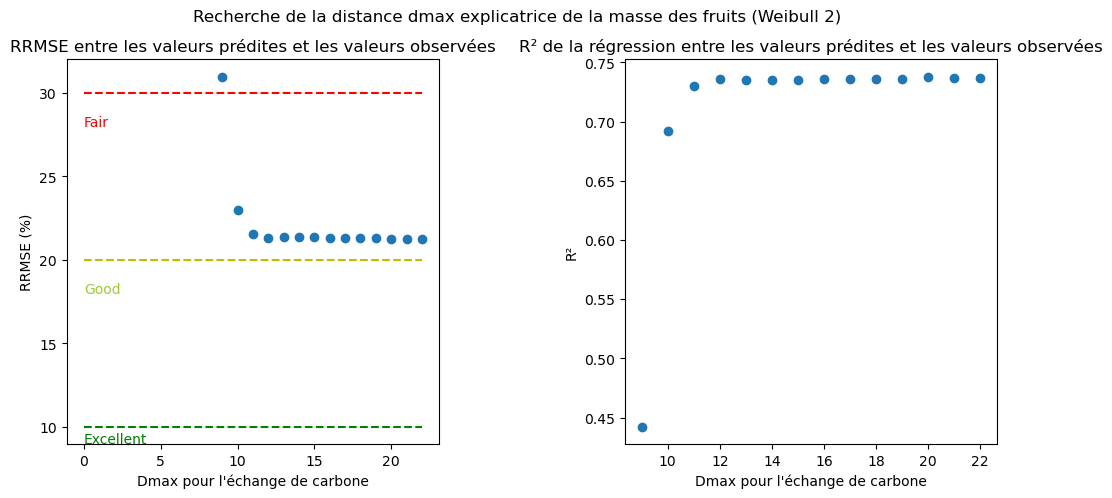

In [272]:
fig=plt.figure(figsize=(12,5))
fig.suptitle("Recherche de la distance dmax explicatrice de la masse des fruits (Weibull 2)")

plt.subplot(121)
plt.scatter(axe, rrmse)
plt.plot([0,22], [10,10], 'g--')
plt.plot([0,22], [20,20], 'y--')
plt.plot([0,22], [30,30], 'r--')
plt.text(x=0, y=9, s="Excellent", c='green')
plt.text(x=0, y=18, s="Good", c='yellowgreen')
plt.text(x=0, y=28, s="Fair", c='red')
plt.title("RRMSE entre les valeurs prédites et les valeurs observées")
plt.xlabel("Dmax pour l'échange de carbone")
plt.ylabel("RRMSE (%)")

plt.subplot(122)
plt.title("R² de la régression entre les valeurs prédites et les valeurs observées")
plt.xlabel("Dmax pour l'échange de carbone")
plt.ylabel("R²")
plt.scatter(axe, rsquared)

plt.subplots_adjust(wspace=0.5)
plt.show()

_Conclusion :_

En distances topologiques, une dmax égale à 12 semble suffisante pour expliquer la masse finale des fruits sur les branches annelées. La prise en compte de la masse sèche n'augmente visiblement que peu la qualité du modèle (la RRMSE diminue de 0.2 seulement).

##  Collecting data on all branches of F14 for geometric distances

Problème : la fonction Musca ne touche que la répartition du carbone entre les fruits. Puisqu'il n'y a qu'un seul fruit par branche annelée sur F14, la friction h n'a pas d'impact.